### Import Liabrary

In [2]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
#from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

2024-12-25 06:10:22.248593: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-25 06:10:22.411407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735087222.474655    3339 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735087222.495499    3339 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-25 06:10:22.657251: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Load the dataset

In [3]:
final_d=pd.read_csv("New_Dataframe.csv")
final_d

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...
84870,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
84871,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1
84872,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1
84873,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1


### EDA

In [4]:
final_d.label.value_counts()

label
1    50084
0    34791
Name: count, dtype: int64

In [5]:
# divide the major and minor classes

df_minority = final_d[final_d['label'] == 0]
df_majority = final_d[final_d['label']== 1]

In [6]:
### Upsampling

from sklearn.utils import resample

df_up_sampled = resample(df_minority, n_samples=50084, random_state=123456)
df_up_sampled

,title,text,label
12847,Turkish court frees opposition journalist on b...,ISTANBUL (Reuters) - A Turkish court freed on ...,0
44381,Trump builds team of bosses to shake up Washin...,WASHINGTON (Reuters) - With more than 20 nomi...,0
37183,Twitter Shares Crash Following Quarterly Earni...,Twitter shares crashed on Thursday following t...,0
47568,Major U.S. Jewish Groups Applaud Trump’s Holoc...,The Algemeiner reports: Leading American Jewis...,0
50374,GRAPHIC VIDEO Shows White Officer Shooting Una...,North Charleston Police Officer Michael T. Sla...,0
...,...,...,...
38048,Iraqi forces complete Kirkuk province takeover...,"BAGHDAD/ERBIL, Iraq (Reuters) - Iraqi forces o...",0
28287,"Army Triumphs at Last, Ending Navy’s 14-Game S...",BALTIMORE — Tradition at the game calls f...,0
32732,Senate race rankings: Dems attack as GOP lays ...,The move would make it easier for the Trump ad...,0
55399,Jailed Kremlin critic calls on Russians to pro...,MOSCOW (Reuters) - Kremlin critic Alexei Naval...,0


In [7]:
# contact both the majority class and up sample data frame
final_data= pd.concat([df_majority, df_up_sampled])
final_data

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
...,...,...,...
38048,Iraqi forces complete Kirkuk province takeover...,"BAGHDAD/ERBIL, Iraq (Reuters) - Iraqi forces o...",0
28287,"Army Triumphs at Last, Ending Navy’s 14-Game S...",BALTIMORE — Tradition at the game calls f...,0
32732,Senate race rankings: Dems attack as GOP lays ...,The move would make it easier for the Trump ad...,0
55399,Jailed Kremlin critic calls on Russians to pro...,MOSCOW (Reuters) - Kremlin critic Alexei Naval...,0


In [8]:
final_data.isna().sum()

title    518
text      39
label      0
dtype: int64

In [9]:
data=final_data.dropna()

In [10]:
data.isna().sum()

title    0
text     0
label    0
dtype: int64

In [11]:
data.label.value_counts()

label
0    50084
1    49527
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x738b99d83760>,
 [Text(-1.1999537103680562, 0.010540065176981937, 'Fake'),
  Text(1.1999537103680562, -0.010540065176982086, 'True')],
 [Text(-0.6999729977146995, 0.006148371353239463, '49.7%'),
  Text(0.6999729977146995, -0.006148371353239549, '50.3%')])

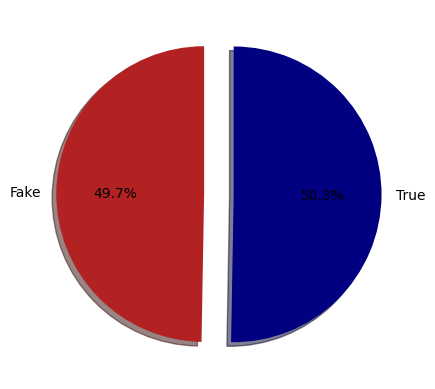

In [12]:
# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

### Train-Test Split

In [13]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
from transformers import BertTokenizer

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define the maximum length for tokenization
MAX_LENGTH = 100  # You can adjust this based on your needs
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    )
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [14]:
# Assuming you have already split your data into train_text, val_text, train_labels, val_labels

# Tokenize the validation data
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=MAX_LENGTH,
    padding=True,
    truncation=True,
    return_tensors='pt'
)

# Prepare validation labels
val_labels = torch.tensor(val_labels.tolist())

# Convert the tokenized sequences to tensors
val_seq = tokens_val['input_ids']
val_mask = tokens_val['attention_mask']

# Wrap them in a TensorDataset and create a DataLoader
val_data = TensorDataset(val_seq, val_mask, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=32)

# Now you can call the evaluate function without errors

## BERT Fine-tuning

### Load pretrained BERT Model

Text(0, 0.5, 'Number of texts')

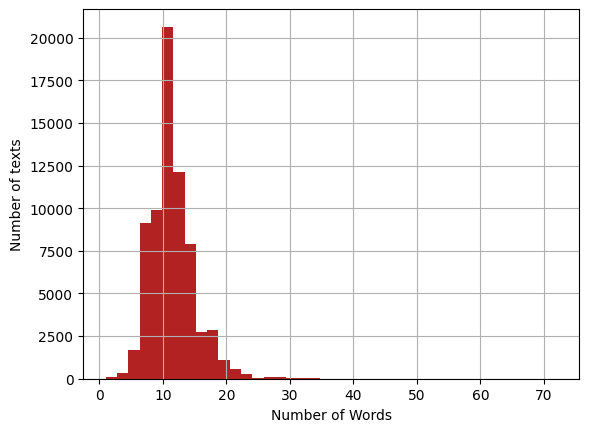

In [15]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [16]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Assuming `data` is a pandas DataFrame containing the columns `text` and `label`
# Tokenize the text
MAX_LENGTH = 100  # Define the maximum length of the text sequences

tokens_train = tokenizer.batch_encode_plus(
    data['text'].tolist(),
    max_length=MAX_LENGTH,
    padding=True,
    truncation=True,
    return_tensors='pt'
)

# Prepare labels
train_labels = torch.tensor(data['label'].tolist())


In [17]:
# Convert the tokenized sequences to tensors
train_seq = tokens_train['input_ids']
train_mask = tokens_train['attention_mask']

# Wrap them in a TensorDataset and create a DataLoader
train_data = TensorDataset(train_seq, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)


In [18]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)  # Dropout for regularization
        self.fc1 = nn.Linear(768, 512)  # First fully connected layer
        self.fc2 = nn.Linear(512, 2)    # Output layer (2 classes: real or fake)
        self.softmax = nn.LogSoftmax(dim=1)  # Softmax for classification
    
    def forward(self, sent_id, mask):
        # Pass the inputs through BERT model
        cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
        x = self.fc1(cls_hs)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [19]:
from transformers import BertModel, BertTokenizer

# Load the pre-trained BERT model
bert = BertModel.from_pretrained('bert-base-uncased')

# Instantiate the custom architecture with the pre-trained BERT model
model = BERT_Arch(bert)


In [20]:
# Freeze the parameters of BERT layers
for param in model.bert.parameters():
    param.requires_grad = False

# Ensure that only the classifier layers are trainable
for param in model.fc1.parameters():
    param.requires_grad = True
for param in model.fc2.parameters():
    param.requires_grad = True


In [21]:
optimizer = AdamW(model.parameters(), lr=1e-5)
cross_entropy = nn.NLLLoss()


In [22]:
def train():
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        # Get the batch data
        sent_id, mask, labels = batch
        optimizer.zero_grad()  # Clear previous gradients
        
        # Get the model predictions
        preds = model(sent_id, mask)
        
        # Compute the loss
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
    
    avg_loss = total_loss / len(train_dataloader)
    return avg_loss


In [23]:
def evaluate():
    model.eval()  # Set model to evaluation mode
    total_loss = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for step, batch in enumerate(val_dataloader):
            # Move batch to the appropriate device (if using GPU, you can modify this accordingly)
            sent_id, mask, labels = [b.to(device) for b in batch]  # Assuming 'device' is defined as "cuda" or "cpu"

            # Forward pass
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_dataloader)  # Compute average loss
    return avg_loss


In [24]:
# Number of epochs
epochs = 15

best_valid_loss = float('inf')
train_losses = []
valid_losses = []

# Training loop
for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}/{epochs}')
    
    # Train the model
    train_loss = train()
    
    # Evaluate the model
    valid_loss = evaluate()

    # Save the model with the best validation loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'fake_news_model.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Training Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


Epoch 1/15
Training Loss: 0.652
Validation Loss: 0.703

Epoch 2/15
Training Loss: 0.623
Validation Loss: 0.684

Epoch 3/15
Training Loss: 0.606
Validation Loss: 0.724

Epoch 4/15
Training Loss: 0.593
Validation Loss: 0.704

Epoch 5/15
Training Loss: 0.584
Validation Loss: 0.694

Epoch 6/15
Training Loss: 0.577
Validation Loss: 0.685

Epoch 7/15
Training Loss: 0.571
Validation Loss: 0.695

Epoch 8/15
Training Loss: 0.567
Validation Loss: 0.720

Epoch 9/15
Training Loss: 0.562
Validation Loss: 0.699

Epoch 10/15
Training Loss: 0.558
Validation Loss: 0.704

Epoch 11/15
Training Loss: 0.556
Validation Loss: 0.694

Epoch 12/15
Training Loss: 0.553
Validation Loss: 0.726

Epoch 13/15
Training Loss: 0.551
Validation Loss: 0.718

Epoch 14/15
Training Loss: 0.549
Validation Loss: 0.730

Epoch 15/15
Training Loss: 0.546
Validation Loss: 0.709


### Model Evaluation

In [25]:
from torch.utils.data import DataLoader, TensorDataset
tokens_test = tokenizer.batch_encode_plus(
    data['text'].tolist(),
    max_length=MAX_LENGTH,
    padding=True,
    truncation=True,
    return_tensors='pt'
)
test_seq = tokens_test['input_ids']
test_mask = tokens_test['attention_mask']
test_y = torch.tensor(data['label'].tolist())
# Create a TensorDataset for the test data
test_data = TensorDataset(test_seq, test_mask, test_y)
test_dataloader = DataLoader(test_data, batch_size=16)  # Adjust batch size as needed

# Evaluate on the test set
model.eval()
all_preds = []

with torch.no_grad():
    for batch in test_dataloader:
        sent_id, mask, labels = batch
        preds = model(sent_id, mask)
        preds = preds.detach().cpu().numpy()
        all_preds.extend(np.argmax(preds, axis=1))

# Convert to numpy array
preds = np.array(all_preds)

# Print classification report
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.65      0.91      0.76     50084
           1       0.85      0.51      0.64     49527

    accuracy                           0.71     99611
   macro avg       0.75      0.71      0.70     99611
weighted avg       0.75      0.71      0.70     99611



In [26]:
from sklearn.metrics import accuracy_score
accu_score=accuracy_score(test_y, preds)
accu_score

0.7137464737830159

In [27]:
from sklearn.metrics import precision_score
precision_s=precision_score(test_y, preds)
precision_s

0.8530528579589368

In [28]:
from sklearn.metrics import recall_score
recall_s=recall_score(test_y, preds)
recall_s

0.5125689018111333

In [29]:
from sklearn.metrics import f1_score
f1_s=f1_score(test_y, preds)
f1_s

0.6403652599450093

### testing on unseen data

In [30]:
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers"                          # True
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 100
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

# Make predictions

with torch.no_grad():

    preds = model(unseen_seq, unseen_mask)

    preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)

# Print the predictions

for text, pred in zip(unseen_news_text, preds):

    print(f"Text: {text}\nPredicted Label: {pred}\n")

Text: Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing
Predicted Label: 1

Text: WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy
Predicted Label: 1

Text: U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources
Predicted Label: 1

Text: Trump administration issues new rules on U.S. visa waivers
Predicted Label: 0



### Save the Model & Tokenizer

In [31]:
import pickle
import torch
from transformers import BertTokenizer

#'model' is trained BERT model and 'tokenizer' is your BERT tokenizer
model_name = 'fake_news_model.pt'  # Name of model file
tokenizer_name = 'bert-base-uncased'  # Name for the tokenizer

# Load the model state dict
model.load_state_dict(torch.load(model_name))

# Save the model in a pickle file
with open('bert_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the tokenizer in a separate pickle file
with open('bert_tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

print("Model saved successfully in 'bert_model.pkl'")
print("Tokenizer saved successfully in 'bert_tokenizer.pkl'")

Model saved successfully in 'bert_model.pkl'
Tokenizer saved successfully in 'bert_tokenizer.pkl'
